In [37]:
import numpy as np
import trimesh
import tqdm 
import random

In [38]:
def uniform_sampling_from_mesh(vertices, faces, sample_num):
    # -------- TODO -----------
    # 1. compute area of each triangles
    # 2. compute probability of each triangles from areas
    # 3. sample N faces according to the probability
    # 4. for each face, sample 1 point
    # Note that FOR-LOOP is not allowed!
    # -------- TODO -----------
    angle_points=vertices[faces]
    p1s=angle_points[:,0,:]
    p2s=angle_points[:,1,:]
    p3s=angle_points[:,2,:]

    a=np.sqrt(np.sum((p1s-p2s)**2,axis=1))
    b=np.sqrt(np.sum((p1s-p3s)**2,axis=1))
    c=np.sqrt(np.sum((p2s-p3s)**2,axis=1))
    s=(a+b+c)/2
    area=np.sqrt(s*(s-a)*(s-b)*(s-c))
    prob=area/np.sum(area)

    face_idx=random.choices(list(range(faces.shape[0])),weights=prob,k=sample_num)
    
    r1=np.random.uniform(0,1,(sample_num,1))
    r2=np.random.uniform(0,1,(sample_num,1))
    r3=1-r1-r2
    uniform_pc=r1*p1s[face_idx]+r2*p2s[face_idx]+r3*p3s[face_idx]
    return area, prob, uniform_pc
        

In [39]:
def farthest_point_sampling(pc, sample_num):
    # -------- TODO -----------
    # FOR LOOP is allowed here.
    # -------- TODO -----------
    n=pc.shape[0]
    init_point_idx=random.choice(list(range(n)))
    res_idx=[init_point_idx]
    for i in range(sample_num):
        t_res=pc[res_idx]
        len_res=t_res.shape[0]
        expand_pc=np.tile(pc,(len_res,1))
        expand_res=np.repeat(t_res,n,axis=0)
        dis=np.sqrt(np.sum((expand_res-expand_pc)**2,axis=1)).reshape(n,len_res)
        dis=np.sum(dis,axis=1)
        max_dis=-1
        max_idx=-1
        for j in range(dis.shape[0]):
            if max_dis<dis[j] and j not in res_idx:
                max_dis=dis[j]
                max_idx=j
        res_idx.append(max_idx)
        
    return pc[res_idx]

In [40]:
# task 1: uniform sampling 

obj_path = 'spot.obj'
mesh = trimesh.load(obj_path)
print('faces shape: ', mesh.faces.shape)
sample_num = 512
area, prob, uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, sample_num)

# Visualization. For you to check your code
np.savetxt('uniform_sampling_vis.txt', uniform_pc)

print('area shape: ',area.shape)
print('prob shape: ',prob.shape)
print('pc shape: ',uniform_pc.shape)
# the result should satisfy: 
#       area.shape = (13712, ) 
#       prob.shape = (13712, ) 
#       uniform_pc.shape = (512, 3) 

# For submission
save_dict = {'area': area, 'prob': prob, 'pc': uniform_pc}
np.save('../results/uniform_sampling_results', save_dict)

faces shape:  (13712, 3)
area shape:  (13712,)
prob shape:  (13712,)
pc shape:  (512, 3)


In [41]:
# task 2: FPS

init_sample_num = 2000
final_sample_num = 512
_,_, tmp_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
fps_pc = farthest_point_sampling(tmp_pc, final_sample_num)

# Visualization. For you to check your code
np.savetxt('fps_vis.txt', fps_pc)

# For submission
np.save('../results/fps_results', fps_pc)

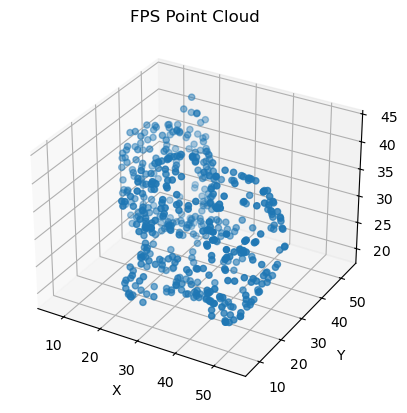

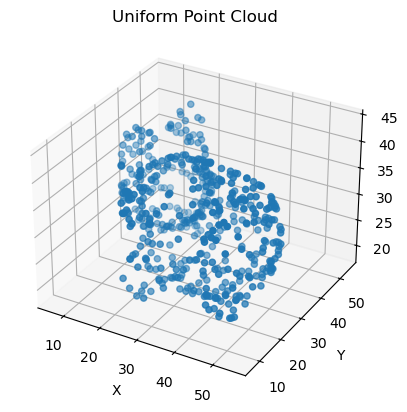

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_pc(pc,title):
    x = pc[:, 0]
    y = pc[:, 1]
    z = pc[:, 2]

    # 创建3D图像
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制点云
    ax.scatter(x, y, z)

    # 设置图像的标题和轴标签
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # 显示图像
    plt.show()
show_pc(fps_pc,"FPS Point Cloud")
show_pc(uniform_pc,"Uniform Point Cloud")


In [43]:
# task 3: metrics

from earthmover.earthmover import earthmover_distance   # EMD may be very slow (1~2mins)
# -----------TODO---------------
# compute chamfer distance and EMD for two point clouds sampled by uniform sampling and FPS.
# sample and compute CD and EMD again. repeat for five times.
# save the mean and var.
# -----------TODO---------------

def chamfer_distance(p1,p2):
    t1=np.tile(p1,(p2.shape[0],1))
    t2=np.repeat(p2,p1.shape[0],axis=0)
    t3=np.sqrt(np.sum((t1-t2)**2,axis=1)).reshape(p2.shape[0],p1.shape[0])
    return (np.mean(np.min(t3,axis=0))+np.mean(np.min(t3,axis=1)))/2

CD_mean = 0
CD_var = 0
EMD_mean = 0
EMD_var = 0
final_sample_num=512
init_sample_num=2000
for _ in range(5):
    _,_,uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, final_sample_num)
    _,_,large_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
    fps_pc = farthest_point_sampling(large_pc, final_sample_num)
    CD=chamfer_distance(uniform_pc,fps_pc)
    EMD=earthmover_distance(uniform_pc,fps_pc)
    CD_mean+=CD/5
    EMD_mean+=EMD/5
    print(CD,EMD)
# For submission
np.save('../results/metrics', {'CD_mean':CD_mean, 'CD_var':CD_var, 'EMD_mean':EMD_mean, 'EMD_var':EMD_var})

1.4251285352780245 3.2191179502534446
1.5279491959622058 2.627942437369226
1.4770870601238513 2.771322986415108
1.5214948696622472 2.813135984400615
1.441678728564533 2.6647746639340797
